In [1]:
import pyspark
import datetime
from pyspark.sql.functions import *
spark = pyspark.sql.SparkSession.builder.getOrCreate()
import pandas as pd
import numpy as np
df_1 = spark.read.csv("project data_3ED.csv", header = True).drop("advertising_id", "language_code", "timezone",
            "duration", "app", "v", "version", "user_id", "platform", "country_code")
df_a = spark.read.csv("active_days_data_for 3ED_project", header = True).drop("version", "user_id",
                                                        "country_code", "platform")

In [177]:
#df_1.show(5)

+--------------------+--------------------+--------------------+--------------------+
|           device_id|          event_type|          session_id|           timestamp|
+--------------------+--------------------+--------------------+--------------------+
|e60b50fc-f706-4ab...|      edit_item_open|1573819337328_e60...|2019-11-15T12:09:...|
|e60b50fc-f706-4ab...|    tool_cutout_open|1573819337328_e60...|2019-11-15T12:09:...|
|e60b50fc-f706-4ab...|  banner_ad_response|1573819337328_e60...|2019-11-15T12:09:...|
|e60b50fc-f706-4ab...|    face_shape_click|1573819337328_e60...|2019-11-15T12:09:...|
|e60b50fc-f706-4ab...|face_shape_fail_t...|1573819337328_e60...|2019-11-15T12:09:...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [5]:
#df_1.select("device_id").distinct().count()
#df_1.select("timestamp").agg(min(col("timestamp")), max(col("timestamp")))
df_2 = df_1.select("device_id", "event_type").withColumn("ed", when(col("event_type")=="editor_done", 1).otherwise(0))
df_3 = df_2.groupBy("device_id").agg(sum("ed").alias("num_ed")).withColumn("ed_count", when(col("num_ed")==0, lit("no_ed")).\
       when(col("num_ed").between(1, 2), lit("ed_1_2")).when(col("num_ed")==3, lit("ed_3")).when(col("num_ed")>3, lit(">3")))
df_3 = df_3.drop("num_ed")
#df_3.show()
df_4 = df_1.join(df_3, df_1.device_id == df_3.device_id, "left").drop(df_3.device_id)
#df_4.show()

In [6]:
#df_active_days.printSchema()
#df_a.show(5)
#df_a.select("device_id").distinct().count()
#df_a.select("active_date").agg(min(col("active_date")), max(col("active_date"))).show()
df_a1 = df_a.filter(col("active_date")>="2019-11-15")
df_a2 = df_a1.withColumn("install_day", to_date("install_timestamp")).withColumn("day_diff", datediff(col("active_date"),\
        col("install_day"))).withColumn("active_week", when(col("day_diff").between(1, 7), lit(1)).\
        when(col("day_diff").between(8, 14), lit(2)).when(col("day_diff").between(15, 21), lit(3)).\
        when(col("day_diff")>22, lit(4)))
#df_a2.show()
df_a3 = df_a2.drop("active_date", "install_day", "day_diff")
df_a4 = df_a3.groupBy("device_id", "install_timestamp").agg(collect_set(col("active_week")).alias("set"))
df_a5 = df_a4.withColumn("ret_level", when(size(col("set"))==0, lit("no_ret")).when(size(col("set")).\
        between(1, 2), lit("low_ret")).when(size(col("set")).between(3, 4), lit("high_ret"))).drop("set")
#df_a5.show(5)

In [7]:
df_new = df_4.join(df_a5, df_4.device_id == df_a5.device_id, "left").drop(df_a5.device_id).drop("install_timestamp")
#df_new.show()
df_ses_time = df_new.select("session_id", "timestamp").groupBy("session_id").agg(min(col("timestamp")), max(col("timestamp")))
df_new = df_new.withColumn("new_timestamp", to_timestamp(col("timestamp"))).drop("timestamp").\
        withColumnRenamed("new_timestamp", "timestamp")
df_8 = df_new.select("session_id", "timestamp").groupBy("session_id").agg(min(col("timestamp")).alias("session_start"),\
        max(col("timestamp")).alias("session_end")).withColumn("session_duration",\
        unix_timestamp(col("session_end"))-unix_timestamp(col("session_start")))
df_8 = df_8.drop("session_start", "session_end")
df_final = df_new.join(df_8, df_new.session_id==df_8.session_id, "left").drop(df_8.session_id)

In [13]:
df_fin = df_final.persist()

retention level and count of ed:  comparing tools

In [22]:
df_tools = df_fin.select("device_id", "event_type", "ed_count", "ret_level").persist()
#df_tools.select("device_id").distinct().count()
df_t = df_tools.groupBy("ed_count", "ret_level").agg(countDistinct(col("device_id")))
df_t.sort("ed_count", "ret_level").show()

+--------+---------+----------------+
|ed_count|ret_level|count(device_id)|
+--------+---------+----------------+
|      >3| high_ret|             219|
|      >3|  low_ret|             264|
|      >3|   no_ret|             115|
|  ed_1_2| high_ret|             213|
|  ed_1_2|  low_ret|             369|
|  ed_1_2|   no_ret|             338|
|    ed_3| high_ret|              55|
|    ed_3|  low_ret|             100|
|    ed_3|   no_ret|              59|
|   no_ed| high_ret|             287|
|   no_ed|  low_ret|             550|
|   no_ed|   no_ret|             669|
+--------+---------+----------------+



In [41]:
df_t1 = df_tools.filter(col("ed_count")=="ed_3").groupBy("ret_level", "event_type").agg(countDistinct(col("device_id")))
df_t1.sort(asc("ret_level"), desc("count(device_id)")).show(200, False)

+---------+-----------------------------------+----------------+
|ret_level|event_type                         |count(device_id)|
+---------+-----------------------------------+----------------+
|high_ret |app_install                        |55              |
|high_ret |app_load                           |55              |
|high_ret |editor_done                        |55              |
|high_ret |app_open                           |55              |
|high_ret |create_flow_open                   |54              |
|high_ret |create_flow_cards_load             |54              |
|high_ret |editor_open                        |54              |
|high_ret |edit_item_open                     |53              |
|high_ret |app_settings_used                  |53              |
|high_ret |registration_open                  |53              |
|high_ret |create_flow_folder_check           |53              |
|high_ret |create_flow_item_view              |53              |
|high_ret |create_flow_ca

convert to pandas dataframes

In [88]:
#n_df = df_tools.toPandas()
df_high = df_t1.filter(col("ret_level")=="high_ret").select("event_type", "count(device_id)")
df_low = df_t1.filter(col("ret_level")=="low_ret").select("event_type", "count(device_id)")
df_no = df_t1.filter(col("ret_level")=="no_ret").select("event_type", "count(device_id)")
pd_high =df_high.toPandas()
pd_low =df_low.toPandas()
pd_no =df_no.toPandas()
pd_high = pd_high.sort_values(by=['count(device_id)'], ascending=False)
pd_low = pd_low.sort_values(by=['count(device_id)'], ascending=False)
pd_no = pd_no.sort_values(by=['count(device_id)'], ascending=False)

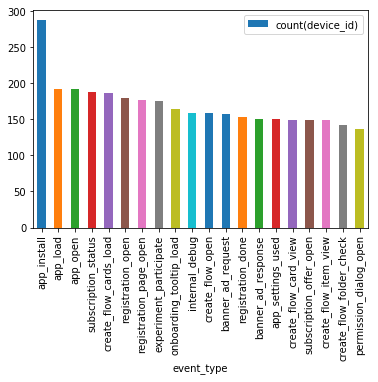

In [95]:
df_t2 = df_tools.filter(col("ed_count")=="no_ed").groupBy("ret_level", "event_type").agg(countDistinct(col("device_id")))
df_t2_high = df_t2.filter(col("ret_level")=="high_ret").select("event_type", "count(device_id)")
pd_t2_high = df_t2_high.toPandas()
pd_t2_high = pd_t2_high.sort_values(by=['count(device_id)'], ascending=False)
pd_t2_high_1 = pd_t2_high[:20]
plt_t2_high= pd_t2_high_1.plot(kind = "bar", x = "event_type", y = "count(device_id)")

create bar charts showing count of "device_id"s by event type

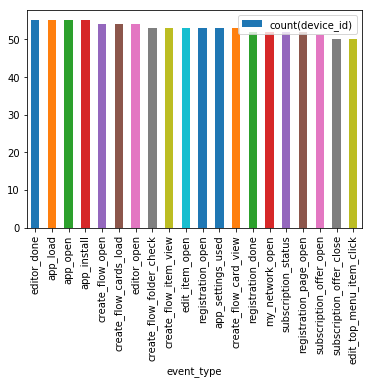

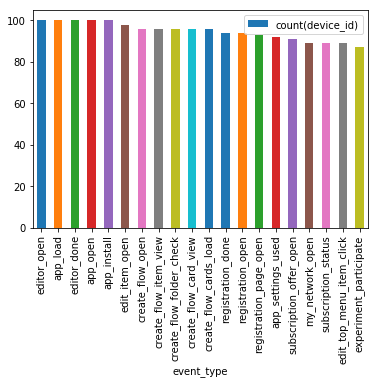

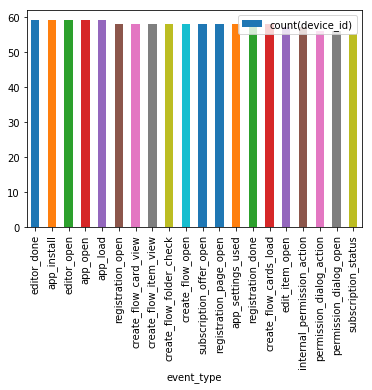

In [91]:
import matplotlib.pyplot as plt
pd_high_1 = pd_high[20:40]
plt_high= pd_high_1.plot(kind = "bar", x = "event_type", y = "count(device_id)")
pd_low_1 = pd_low[20:40]
plt_low = pd_low_1.plot(kind = "bar", x = "event_type", y = "count(device_id)")
pd_no_1 = pd_no[20:40]
plt_no = pd_no_1.plot(kind = "bar", x = "event_type", y = "count(device_id)")

! need separate data on tool names

retention level and count of ed: comparing session durations

In [97]:
df_dur = df_fin.select("device_id", "session_duration", "ed_count", "ret_level").persist()

In [110]:
df_dur_1 = df_dur.groupBy("ed_count", "ret_level").agg(countDistinct(col("device_id")), avg(col("session_duration"))).\
           sort("ed_count", "ret_level")
pd_dur_high = df_dur_1.toPandas()
pd_dur_high

,ed_count,ret_level,count(device_id),avg(session_duration)
0,>3,high_ret,219,1051.964474
1,>3,low_ret,264,1007.618533
2,>3,no_ret,115,1174.662247
3,ed_1_2,high_ret,213,1303.939338
4,ed_1_2,low_ret,369,1131.480072
5,ed_1_2,no_ret,338,947.963356
6,ed_3,high_ret,55,611.465137
7,ed_3,low_ret,100,1021.907726
8,ed_3,no_ret,59,794.254663
9,no_ed,high_ret,287,735.954298


in case of users doing 3 ed there is no strong positive correlation between session duration between
highly active and no active users, the same for users who didn't do ed at all, so most probably 
session duration is not an important explanatory variable for our case.


In [26]:
#PySpark general functions
def group_count(dataframe, group_col, count):
    count_col = count.map(lambda c: countDistinct(col(c)).alias("count_"+c))
    grouped_frame = dataframe.groupBy(group_col.head, group_col.tail).agg(count_col.head, count_col.tail)
    return grouped_frame
def avg_session_duration(dataframe):
    frame = dataframe.withColumn("date", to_date(dataframe("timestamp")))
    session_id_col = dataframe("session_id")
    time_col = dataframe("timestamp")
    frame_filtered = dataframe.select("session_id", "timestamp").distinct()
    new_frame = frame_filtered.groupBy(session_id_col).agg(min(time_col).alias("session_start"), max(time_col).\
                alias("session_end")).withColumn("duration_seconds",\
                unix_timestamp(col("session_end"))-unix_timestamp(col("session_start"))) 
    avg_duration = new_frame.agg(round(avg(col("duration_seconds")))).take(1)(0)(0).toString.toDouble
    return avg_duration
        
avg_session_duration()   
    

In [ ]:
def DAU(dataframe:DataFrame, day:String):Int = {
        var frame = dataframe.withColumn("date", to_date(col("timestamp")))
        var date_col = frame("date")
        var device_id_col = frame("device_id")
        var dau = frame.filter(date_col===day).agg(countDistinct(device_id_col)).take(1)(0)(0).toString.toInt
        dau
    }
def avg_DAU(dataframe:DataFrame):Double = {
        var frame = dataframe.withColumn("date", to_date(col("timestamp")))
        var avg_DAU_frame = group_count(frame, Array("date"), Array("device_id")).
                            agg(round(avg(col("count_device_id"))))  
        var avg_dau = avg_DAU_frame.take(1)(0)(0).toString.toDouble
        avg_dau
    }
def MAU(dataframe:DataFrame, month_num:String):Int = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp"))).
                       withColumn("month", month(dataframe("timestamp")))                
        var month_col = frame("month")
        var device_id_col = frame("device_id")
        var mau = frame.filter(month_col===month_num).agg(countDistinct(device_id_col)).take(1)(0)(0).toString.toInt
        mau
    }
def avg_MAU(dataframe:DataFrame):Double = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp"))).
                    withColumn("month", month(dataframe("timestamp")))
        var avg_MAU_frame = group_count(frame, Array("month"), Array("device_id")).
                            agg(round(avg(col("count_device_id"))))  
        var avg_mau = avg_MAU_frame.take(1)(0)(0).toString.toDouble
        avg_mau
    }
def YAU(dataframe:DataFrame, year_num:String):Int = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp"))).
                    withColumn("month", month(dataframe("timestamp"))).withColumn("year", year(dataframe("timestamp"))) 
        var year_col = frame("year")
        var device_id_col = frame("device_id")
        var yau = frame.filter(year_col===year_num).agg(countDistinct(device_id_col)).take(1)(0)(0).toString.toInt
        yau
    }
def avg_YAU(dataframe:DataFrame):Double = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp"))).
                    withColumn("month", month(dataframe("timestamp"))).withColumn("year", year(dataframe("timestamp")))
        var avg_YAU_frame = group_count(frame, Array("year"), Array("device_id")).
                            agg(round(avg(col("count_device_id"))))  
        var avg_yau = avg_YAU_frame.take(1)(0)(0).toString.toDouble
        avg_yau
    }
def stickiness(dataframe:DataFrame):Double = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp"))).
                    withColumn("month", month(dataframe("timestamp")))
        var stickiness_raw = avg_DAU(frame)*100/avg_MAU(frame)       
        var stickiness = scala.math.round(stickiness_raw)
        stickiness
    } 
def engagement(dataframe:DataFrame):Double = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp")))
        var avg_dau = avg_DAU(frame)
        var frame_1 = group_count(frame, Array("date"), Array("session_id")).
                      agg(round(avg(col("count_session_id"))))
        var sessions_num = frame_1.take(1)(0)(0).toString.toDouble
        var avg_sessions_per_dau = scala.math.round(sessions_num/avg_dau)
        avg_sessions_per_dau
    }
def avg_session_duration(dataframe:DataFrame):Double = {
        frame = dataframe.withColumn("date", to_date(dataframe("timestamp")))
        session_id_col = frame("session_id")
        time_col = frame("timestamp")
        frame_filtered = frame.select("session_id", "timestamp").distinct()
        new_frame = frame_filtered.groupBy(session_id_col).agg(min(time_col).as("session_start"), max(time_col).
                        as("session_end")).withColumn("duration_seconds", unix_timestamp(col("session_end"))-
                        unix_timestamp(col("session_start"))) 
        avg_duration = new_frame.agg(round(avg(col("duration_seconds")))).take(1)(0)(0).toString.toDouble
   
       avg_duration
        
   }

def retention(dataframe:DataFrame, number_of_days:Int):Unit = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp")))
        var device_id_col = frame("device_id")
        var date_col = frame("date")
        var df_1 = group_count(frame, Array("date"), Array("device_id")).withColumnRenamed("date", "date1")
        var df_2 = frame.select("date", "device_id").groupBy(date_col).agg(collect_set(device_id_col).as("device_id_set"))
        var df_join = df_1.join(df_2, df_1("date1") <=> df_2("date"), "inner")
        var window_spec = Window.orderBy(date_col)
        var df_3 = df_join.withColumn("set_after_days", lead("device_id_set", number_of_days) over window_spec)
        var df_4 = df_3.withColumn("common_id_set", array_intersect(col("device_id_set"), col("set_after_days")))
        var df_5 = df_4.withColumn("count_ret_ids", size(col("common_id_set"))).withColumn("retention_rate",
                    round(col("count_ret_ids")*100/col("count_device_id"), 2)).drop("date1", "device_id_set", 
                    "set_after_days", "common_id_set")
        var avg_ret_rate = df_5.agg(round(avg(col("retention_rate")), 1).as("avg_retention_rate_over_time_period"))
        println(avg_ret_rate.show())
    }

def conversion_rate(dataframe:DataFrame, stage1:String, stage2:String):Unit = {
     var frame = dataframe.select("event_type", "session_id", "timestamp")
     var event_col = frame("event_type")
     var window_spec = Window.partitionBy("session_id").orderBy("timestamp")
     var count_stage_1 = group_count(frame.filter(event_col === stage1), Array("event_type"), Array("session_id")).
                         take(1)(0)(1).toString.toDouble
     val df_event = frame.filter(event_col === stage1 || event_col === stage2).
                    withColumn("lead", lead(event_col, 1) over window_spec).filter(event_col === stage1).
                    withColumn("concat_col", concat(event_col, lit(" , "), col("lead")))
     val count_stage_2 = group_count(df_event.filter(col("concat_col") === stage1+" , "+stage2), 
                       Array("concat_col"), Array("session_id")).take(1)(0)(1).toString.toInt
     val conversion_rate = count_stage_2*100/count_stage_1
                                      
     println(count_stage_1)
     println(count_stage_2)
     println("conversion rate: "+conversion_rate)
 }

def most_popular_five_consecutive_events(dataframe:DataFrame):Unit = {
        
        var window = Window.partitionBy("session_id").orderBy("timestamp")
        var new_df = dataframe.
        withColumn("event_2", lead("event_type", 1) over window).withColumn("event_3", lead("event_type", 2) over window).
        withColumn("event_4", lead("event_type", 3) over window).withColumn("event_5", lead("event_type", 4) over window).
        withColumn("5_events", concat(col("event_type"),lit(","),col("event_2"),lit(","),col("event_3"),
        lit(","),col("event_4"),lit(","),col("event_5"))).select("session_id","5_events").groupBy("5_events").
        agg(countDistinct("session_id").as("number_of_users")).orderBy(col("number_of_users").desc).
        withColumn("percent_of_all_users",round(col("number_of_users")/dataframe.agg(countDistinct("session_id")).
        take(1)(0)(0).toString.toInt*100,2)).show(7, false)
    }
def event_description(dataframe:DataFrame, new_event:String):Unit = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp")))
        var event_col = frame("event_type")
        var frame_1 = frame.filter(event_col === new_event)
        var frame_2 = group_count(frame_1, Array("date"), Array("device_id"))
        var description = frame_2.describe()
        var quantiles = frame_2.stat.approxQuantile("count_device_id", Array(0.25, 0.5, 0.75), 0.0)
        var Q1 = quantiles(0)
        var median = quantiles(1)
        var Q3 = quantiles(2)
        var IQR = Q3-Q1
        var lower_outlier_range = Q1 - 1.5*IQR
        var upper_outlier_range = Q3 + 1.5*IQR
        var outliers = frame_2.filter(col("count_device_id")<=lower_outlier_range || col("count_device_id")>= 
                       upper_outlier_range).withColumnRenamed("date", "outlier_date").withColumnRenamed("count_device_id",
                       "outliers")
        println(description.show())
        println("Q1: "+Q1+"\n"+"median: "+median+"\n"+"Q3: "+Q3)
        println(outliers.show(30))
        
    }
def most_popular_ten_events(dataframe:DataFrame, time_start:String, time_end:String):Unit = {
        var frame = dataframe.withColumn("date", to_date(dataframe("timestamp")))
        var date_col = frame("date")
        var frame_1 = frame.filter(date_col>=to_date(lit(time_start)) && date_col<=to_date(lit(time_end)))
        var frame_2 = group_count(frame_1, Array("event_type"), Array("session_id")).sort(desc("count_session_id")).limit(10)
        println(frame_2.show(false))
    }
def most_used_tools_combinations(dataframe:DataFrame):Unit = {
        
        var window = Window.partitionBy("session_id").orderBy("timestamp")
        var new_df = dataframe.
        withColumn("tool_2", lead("tool", 1) over window).
        withColumn("tools_comb", concat(col("tool"),lit(","),col("tool_2"))).select("session_id","tools_comb").
        groupBy("tools_comb").agg(countDistinct("session_id").as("number_of_users")).orderBy(col("number_of_users").desc).
        withColumn("percent_of_all_users",round(col("number_of_users")/dataframe.agg(countDistinct("session_id")).
        take(1)(0)(0).toString.toInt*100,2)).show(7, false)
    }
